In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo
import nengo_dl
import tensorflow as tf

import davis_tracking

c:\users\terry\py3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Here's a bunch of parameters.  They're currently set to the best I've been able to find that still lead to at most 1024 neurons per ensemble.

In [2]:
dt = 0.01                 # time step between samples for generating training data
decay_time = 0.01         # low-pass filter on input
separate_channels = True  # separate channels for positive and negative spikes
saturation = 5            # clip input values
merge = 3                 # merge pixels to reduce the image size (1 is no reduction, 2 merges 2x2 pixels down to 1 pixel, etc)

spatial_size = 20         # size of spatial pools 
spatial_stride = 10       # stride between spatial pools

n_features_1 = 28         # parameters for first convolution layer
kernel_size_1 = 5
stride_1 = 3

n_features_2 = 64         # parameters for second convolution layer
kernel_size_2 = 3
stride_2 = 1

n_parallel = 2            # number of parallel ensembles
n_local = 1               # number of connections between parallel ensemble groups

Now let's load some data.  We'll just grab one example set of data for this minimal example.

Notice that we use the `merge` parameter to reduce it from 180 x 240 to 60 x 80.   Also, we're setting `separate_channels` to True, so we get two channels.  That means we actually get a 120 x 80 image (which we will later treat as a (2,60,80) two-channel image).

In [3]:
times, imgs, targs = davis_tracking.load_data('../dataset/retinaTest95.events',
                                              dt=dt, decay_time=decay_time,
                                              separate_channels=separate_channels, 
                                              saturation=saturation, merge=merge)
targs = targs[:, :2]    # just keep the x and y values for the targets
print('images:', imgs.shape)
print('targets:', targs.shape)

images: (157, 120, 80)
targets: (157, 2)


Now we build the model.  It's just two layers of convolution after the spatial splitting.

In [5]:
if separate_channels:
    shape = (2, 180//merge, 240//merge)
else:
    shape = (1, 180//merge, 240//merge)

dimensions = shape[0]*shape[1]*shape[2]

max_rate = 100
amp = 1 / max_rate

model = nengo.Network()
with model:
    model.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear(amplitude=amp)
    model.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    model.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    model.config[nengo.Connection].synapse = None

    inp = nengo.Node(
        nengo.processes.PresentInput(imgs.reshape(-1, dimensions), 0.001),
        size_out=dimensions,
        )

    out = nengo.Node(None, size_in=2)

    convnet = davis_tracking.ConvNet(nengo.Network(label='convnet'))
    convnet.make_input_layer(
            shape,
            spatial_stride=(spatial_stride, spatial_stride), 
            spatial_size=(spatial_size, spatial_size))
    nengo.Connection(inp, convnet.input)
    convnet.make_middle_layer(n_features=n_features_1, n_parallel=n_parallel, n_local=1,
                              kernel_stride=(stride_1,stride_1), kernel_size=(kernel_size_1, kernel_size_1))
    convnet.make_middle_layer(n_features=n_features_2, n_parallel=n_parallel, n_local=n_local,
                              kernel_stride=(stride_2,stride_2), kernel_size=(kernel_size_2, kernel_size_2))
    convnet.make_output_layer(2)
    nengo.Connection(convnet.output, out)

    p_out = nengo.Probe(out)


Let's take a look at the network structure, just to make sure.

In [6]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model)

Now let's split this into training and testing data.  For a real example we'd use a completely different data set for testing, but here we just split even and odd data.

In [7]:
inputs_train = imgs[::2]
inputs_test = imgs[1::2]
targets_train = targs[::2]
targets_test = targs[1::2]

minibatch_size = 200
n_epochs = 1
learning_rate = 1e-4

And now let's train the network.

In [7]:
N = len(inputs_train)
n_steps = int(np.ceil(N/minibatch_size))
dl_train_data = {inp: np.resize(inputs_train, (minibatch_size, n_steps, dimensions)),
                 p_out: np.resize(targets_train, (minibatch_size, n_steps, 2))}
N = len(inputs_test)
n_steps = int(np.ceil(N/minibatch_size))
dl_test_data = {inp: np.resize(inputs_test, (minibatch_size, n_steps, dimensions)),
                p_out: np.resize(targets_test, (minibatch_size, n_steps, 2))}
with nengo_dl.Simulator(model, minibatch_size=minibatch_size) as sim:
    loss_pre = sim.loss(dl_test_data)

    sim.train(dl_train_data, tf.train.RMSPropOptimizer(learning_rate=learning_rate),
          n_epochs=n_epochs)

    loss_post = sim.loss(dl_test_data)

    sim.run_steps(n_steps, data=dl_test_data)



|###################  Building network (30%)                     | ETA: 0:00:00

c:\users\terry\documents\github\nengo-dl\nengo_dl\simulator.py:94: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


Build finished in 0:00:00                                                      
Optimization finished in 0:00:08                                               


|########Constructing graph: creating base arrays (15100%)##############################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

|########Constructing graph: creating base arrays (16300%)##############################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

|########Constructing graph: creating base arrays (17100%)##############################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

|########Constructing graph: creating base arrays (17800%)##############################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

|###Constructing graph: creating base arrays (18600%)###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

|###Constructing graph: creating base arrays (19500%)###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

|###Constructing graph: creating base arrays (20600%)###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

|###Constructing graph: creating base arrays (21400%)###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

|###Constructing graph: creating base arrays (22400%)###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

|###Constructing graph: creating base arrays (23500%)###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

|###Constructing graph: creating base arrays (24600%)###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

|###Constructing graph: creating base arrays (25400%)###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

|############Constructing graph: pre-build stage (35%)           | ETA: 0:00:03

c:\users\terry\documents\github\nengo-dl\nengo_dl\transform_builders.py:43: UserWarning: TensorFlow does not support convolution with channels_last=False on the CPU; inputs will be transformed to channels_last=True
  "to channels_last=True", UserWarning)


Construction finished in 0:00:08                                               
Calculation finished in 0:00:20                                                
Training finished in 0:00:55 (loss: 1653.6835)                                 
Calculation finished in 0:00:07                                                
Simulation finished in 0:00:10                                                 


The result for this is horrible, since we only trained one epoch.  But the basic principle is right.

Notice that we need to multiply the output by `merge` in order to get it back into the right units.

[148.7769764   87.44594598]


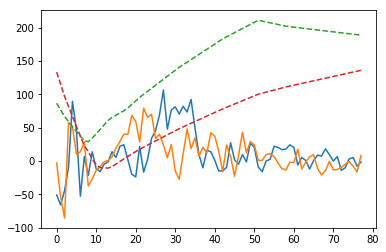

In [8]:

data = sim.data[p_out].reshape(-1,2)[:len(targets_test)]

rmse_test = np.sqrt(np.mean((targets_test-data)**2, axis=0))*merge          
plt.plot(data*merge)
plt.plot(targets_test*merge, ls='--')

print(rmse_test)